# Assignment 2 - GloVe : Global Vectors for Word Representation
Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd

# 1. Compare them based on syntactic accuracy and semantic accuracy, 
- similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) 
- NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....

## 1. Load Data
A real corpus

In [2]:
#Training Set
# Use corpus from nltk
import nltk
from nltk.corpus import brown
nltk.download('brown')
corpus_tokenized = nltk.corpus.brown.sents(categories='news')
len(corpus_tokenized)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Guntsv\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


4623

In [3]:
#1. tokenize
corpus_tokenized = [[word.lower() for word in sent] for sent in corpus_tokenized]
print(corpus_tokenized[:2])

[['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']]


In [4]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#adding unknown word
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

voc_size = len(vocabs)
voc_size

13113

In [5]:
#preparing all_vocabs
batch_size = 2

def prepare_seqeunce(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_seqeunce(list(vocabs),word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 13113])

In [6]:
index2word = {v:k for k,v in word2index.items()}
# index2word

## 2. Model

### 2.1 GloVe
<img src ="figures/glove.png">

#### 2.1.1 Co-occurence Matrix X

Count the occurrences of pair of words using window size of 1 (you can use 2, 3, 4, up to you)

E.g., Dog loves to eat meal.

['Dog','loves',1],['loves','to',1]

In [7]:
#use Counter to first count stuffs
from collections import Counter
# print(corpus_tokenized)

#count the frequency of each word
#we somehow need this to claiclate the probability Pi
X_i = Counter(flatten(corpus_tokenized)) #merge all list ... (flattten is a function I defines)
# X_i['apple'] #get the probability of apple

In [8]:
skip_grams = []
cbows = []
window_size = 2
#for each corpus
for sent in corpus_tokenized:
    for i in range(1,len(sent)-window_size): #start from 2 to second last
        context_word = []
        # print(sent[i])
        center_word = sent[i]
        for j in range(window_size):
            outside_word = [sent[i-j-1],sent[i+j+1]] #window_size adjustable
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                context_word.append(o)
                skip_grams.append((center_word,o))
            cbows.append((context_word,center_word))

In [9]:
#since we have these occcurences, we can count, to make our co-occurence matrix!!!
X_ik_skipgram = Counter(skip_grams)
# X_ik_skipgram

#### 2.1.2. Weighting function f

GloVe includes a weighting function to scale down too frequent words.

In [10]:
def weighting(w_i,w_j,X_ik): #we need w_i and w_j, because we can try its-co-occurrences, if it's too big, we scale it down
    #check whether the co-occurrences between these two word exits??
    try:
        x_ij = X_ik[(w_i,w_j)]
    except:
        x_ij = 1 #why one, so that the probability thingly won't break....
    
    #maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75

    #if the co-occurrences does not exceed x_max, cale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1 #this is the maximum probability you can havve
    
    return result

In [11]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} #for keeping the co-occurrences
weighting_dic = {} #for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs,2): #we need to also think its reverse
    # print(bigram)
    #if this bigram exists in X_ik_skipgrams
    #we gonna add this to our c-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram] #get the co-occurrences
        X_ik[bigram] = cooc + 1 #this is agian basically label smoothing.... (stability issue (especailly when divide something))
        X_ik[(bigram[1],bigram[0])] = cooc + 1 #trick to get all pairs
    else: #otherwise, do nothing
        pass
    #apply the weighting function using this co-occurrence matrix thingly
    weighting_dic[bigram] = weighting(bigram[0],bigram[1],X_ik)
    weighting_dic[(bigram[1],bigram[0])] = weighting(bigram[1],bigram[0],X_ik)

#### 2.1.3. Prepare train data
You move the window along, and create those tuples as we said in class


<img src = "figures/glove_weighting_func.png" width=400>

In [12]:
import math

def random_batch(batch_size,word_sequence,skip_grams,X_ik,weighting_dic):
    #loop through skipgram, and change it id because when sending model, it must number 
    skipg_grams_id = [(word2index[skip_gram[0]],word2index[skip_gram[1]]) for skip_gram in skip_grams]
    #randomly pick 'batch_size' indexes
    number_of_choices = len(skipg_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among  these random indexes
    
    # print(random_index)
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #xij (in batches)
    random_weighting = [] #f(xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skipg_grams_id[i][0]]) #same reason why I put bracket here....
        random_labels.append([skipg_grams_id[i][1]])

        #get coocs
        #first check whether it exists.....
        pair = skip_grams[i] #e.g., ['banana','fruit']
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing

        random_coocs.append([math.log(cooc)]) #1. why log, #2 why bracket -> size ==> (,1) #my neural network excepts (,1)
        
        #for weighting
        weighting = weighting_dic[pair] #why not user try... maybe it does not exist
        random_weighting.append(weighting)

    return np.array(random_inputs),np.array(random_labels),np.array(random_coocs),np.array(random_weighting)
        #return xi,xj
        #return cooc Xij
        #return weighting

In [13]:
batch_size = 2
input, target, coocs, weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)
input, target, coocs, weightin

(array([[ 2168],
        [12614]]),
 array([[ 561],
        [5275]]),
 array([[0.69314718],
        [0.69314718]]),
 array([0.05318296, 0.05318296]))

In [14]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vectos for outside words
#v_C - vector for center word
#u_w - vectors of all vocabs

class GloVe(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(GloVe,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        
        self.bias_i = nn.Embedding(voc_size, 1)
        self.bias_j = nn.Embedding(voc_size, 1)
    def forward(self, center_words, outside_words, coocs, weighting):
        #get the embedding of center_words and outside_words
        center_embeds = self.embedding_center_word(center_words)
        outside_embeds = self.embedding_outside_word(outside_words)

        #create biases #create unique embedding (voc_size,1)
        inner_product = center_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        bias_i = self.bias_i(center_words).squeeze(1) #center
        bias_j = self.bias_j(outside_words).squeeze(1) #target
        #do the product between wi and wj
        loss = weighting * torch.pow(inner_product + bias_i + bias_j - coocs, 2)
        
        return torch.sum(loss)

In [15]:
def random_batch_word2vec(batch_size, corpus, window_size=1,architecture='skipgram'):
    skipgrams = []
    cbows = []
    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(window_size,len(sent)-window_size): #start from 2 to second last
            context_word = []
            # print(sent[i])
            center_word = word2index[sent[i]]
            for j in range(window_size):
                outside_word = [word2index[sent[i-j-1]],word2index[sent[i+j+1]]] #window_size adjustable
                #here we want to create (banana, apple), (banana, fruit) append to some list
                for o in outside_word:
                    context_word.append(o)
                    skipgrams.append([center_word,o])
                cbows.append([context_word,center_word])

    if architecture == 'skipgram':
        arch = skipgrams
    else:
        arch = cbows
        
    #only get a batch, not the entire lsit
    random_index = np.random.choice(range(len(arch)),batch_size,replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [] , []
    for index in random_index:
        # print(arch[index])
        random_inputs.append([arch[index][0]]) #center words, this will be as shape of (1,) -> (1,1) for modeling
        random_labels.append([arch[index][1]])

    return np.array(random_inputs),np.array(random_labels)

### 2.2 Skipgram

In [16]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vectos for outside words
#v_C - vector for center word
#u_w - vectors of all vocabs

class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar

        return loss_fn

### 2.3 CBOW

In [17]:
class CBOW(nn.Module): #same as skipgram
    def __init__(self,voc_size, emb_size):
        super(CBOW,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

### 2.4 Negative Sampling

A function to get negavtive samples, based o nthe current center and outsode words in the batch

#### 2.4.1 Unigram Distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [18]:
z = 0.0001 #scaling up lower frequency terms

In [123]:
#count all the occurence of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
# word_count

In [20]:
import random
def prepare_sequence(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

In [21]:
#the model will accept three vectors - u_o, v_c, u_k
#u_o - vectos for outside words
#v_C - vector for center word
#u_k - vectors for negative word

class SkipgramNeg(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(SkipgramNeg,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words  (batch_size,1)
        #negative_words (batch_size,k) 
        center_embed    = self.embedding_center_word(center_words)      #(batch_size,1, emb_size)
        outside_embed   = self.embedding_outside_word(outside_words)   #(batch_size,1, emb_size)
        neg_embed       = self.embedding_outside_word(negative_words)      #(batch_size,k, emb_size)
        
        uovc            = outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc            = -neg_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc_sum        =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum) #(batch_size,1)+(batch_size,1)
        
        return -torch.mean(loss) #scalar, loss should be scalar, to call backward()

# 3. Training

In [44]:
voc_size = len(vocabs)
batch_size = 2 #why? no reason
emb_size = 50 #why? no reason; usually 50, 100, 300 but 2 so we can plot (50 can also plot, but need PCA)
models = [Skipgram(voc_size,emb_size), CBOW(voc_size,emb_size), SkipgramNeg(voc_size, emb_size), GloVe(voc_size,emb_size)]
models_name = ['Skipgram','CBOW','NEG','GloVe'] 

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
import time
import pickle
num_epochs = 500
for idx, model in enumerate(models):
    criterion = nn.CrossEntropyLoss() #-log
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print(f'Model : {models_name[idx]}')
    #for epoch
    start_time = time.time()
    for epoch in range(num_epochs):
        #get random batch
        if (idx == 0) or (idx == 2):
            input_batch, label_batch = random_batch_word2vec(batch_size,corpus_tokenized,window_size=2,architecture='skipgram')
            input_batch = torch.LongTensor(input_batch)
            label_batch = torch.LongTensor(label_batch)
            loss = model(input_batch,label_batch,all_vocabs)
        if idx == 1:    
            input_batch, label_batch = random_batch_word2vec(batch_size,corpus_tokenized,window_size=2,architecture='cbow')
            input_batch = torch.LongTensor(input_batch).view(batch_size,window_size*2)
            label_batch = torch.LongTensor(label_batch).view(-1,1)
            loss = model(input_batch,label_batch,all_vocabs)
        if idx == 3:
            input, label, cooc, weightin = random_batch(batch_size,corpus_tokenized,skip_grams,X_ik,weighting_dic)
            cooc_batch = torch.FloatTensor(cooc)
            weightin_batch = torch.FloatTensor(weightin)
            input_batch = torch.LongTensor(input)
            label_batch = torch.LongTensor(label)
            loss = model(input_batch,label_batch,cooc_batch,weightin_batch)

        #backpropagate
        loss.backward()
        #update alpha
        optimizer.step()

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        #print epoch loss
        if (epoch + 1) % 100 == 0:
            print(f'Epoch : {epoch+1} | Loss : {loss:.6f} | Time : {epoch_mins}m {epoch_secs}s')
            
    torch.save(model.state_dict(), "./model/"+models_name[idx]+".pth")
    with open("./model/"+models_name[idx]+".pkl",'wb') as f:
        pickle.dump(model,f)
    # break

Model : Skipgram
Epoch : 100 | Loss : 24.663319 | Time : 1m 15s
Epoch : 200 | Loss : 25.925415 | Time : 2m 31s
Epoch : 300 | Loss : 48.776756 | Time : 3m 46s
Epoch : 400 | Loss : 24.188061 | Time : 5m 4s
Epoch : 500 | Loss : 22.145897 | Time : 6m 30s
Model : CBOW
Epoch : 100 | Loss : 32.855370 | Time : 1m 21s
Epoch : 200 | Loss : 32.047951 | Time : 2m 47s
Epoch : 300 | Loss : 24.753788 | Time : 4m 4s
Epoch : 400 | Loss : 21.954782 | Time : 5m 26s
Epoch : 500 | Loss : 26.298782 | Time : 6m 49s
Model : NEG
Epoch : 100 | Loss : 2722.873047 | Time : 1m 20s
Epoch : 200 | Loss : 18.244280 | Time : 2m 43s
Epoch : 300 | Loss : 7825.445312 | Time : 4m 3s
Epoch : 400 | Loss : 3.962481 | Time : 5m 22s
Epoch : 500 | Loss : 2829.480957 | Time : 6m 44s
Model : GloVe
Epoch : 100 | Loss : 2310.856201 | Time : 0m 11s
Epoch : 200 | Loss : 264.488312 | Time : 0m 22s
Epoch : 300 | Loss : 1713.151855 | Time : 0m 33s
Epoch : 400 | Loss : 651.568420 | Time : 0m 44s
Epoch : 500 | Loss : 2357.380371 | Time : 0

In [47]:
'''
Model : Skipgram
Epoch : 100 | Loss : 24.663319 | Time : 1m 15s
Epoch : 200 | Loss : 25.925415 | Time : 2m 31s
Epoch : 300 | Loss : 48.776756 | Time : 3m 46s
Epoch : 400 | Loss : 24.188061 | Time : 5m 4s
Epoch : 500 | Loss : 22.145897 | Time : 6m 30s
Model : CBOW
Epoch : 100 | Loss : 32.855370 | Time : 1m 21s
Epoch : 200 | Loss : 32.047951 | Time : 2m 47s
Epoch : 300 | Loss : 24.753788 | Time : 4m 4s
Epoch : 400 | Loss : 21.954782 | Time : 5m 26s
Epoch : 500 | Loss : 26.298782 | Time : 6m 49s
Model : NEG
Epoch : 100 | Loss : 2722.873047 | Time : 1m 20s
Epoch : 200 | Loss : 18.244280 | Time : 2m 43s
Epoch : 300 | Loss : 7825.445312 | Time : 4m 3s
Epoch : 400 | Loss : 3.962481 | Time : 5m 22s
Epoch : 500 | Loss : 2829.480957 | Time : 6m 44s
Model : GloVe
Epoch : 100 | Loss : 2310.856201 | Time : 0m 11s
Epoch : 200 | Loss : 264.488312 | Time : 0m 22s
Epoch : 300 | Loss : 1713.151855 | Time : 0m 33s
Epoch : 400 | Loss : 651.568420 | Time : 0m 44s
Epoch : 500 | Loss : 2357.380371 | Time : 0m 55s
'''

'Model : Skipgram\nEpoch : 100 | Loss : 24.663319 | Time : 1m 15s\nEpoch : 200 | Loss : 25.925415 | Time : 2m 31s\nEpoch : 300 | Loss : 48.776756 | Time : 3m 46s\nEpoch : 400 | Loss : 24.188061 | Time : 5m 4s\nEpoch : 500 | Loss : 22.145897 | Time : 6m 30s\nModel : CBOW\nEpoch : 100 | Loss : 32.855370 | Time : 1m 21s\nEpoch : 200 | Loss : 32.047951 | Time : 2m 47s\nEpoch : 300 | Loss : 24.753788 | Time : 4m 4s\nEpoch : 400 | Loss : 21.954782 | Time : 5m 26s\nEpoch : 500 | Loss : 26.298782 | Time : 6m 49s\nModel : NEG\nEpoch : 100 | Loss : 2722.873047 | Time : 1m 20s\nEpoch : 200 | Loss : 18.244280 | Time : 2m 43s\nEpoch : 300 | Loss : 7825.445312 | Time : 4m 3s\nEpoch : 400 | Loss : 3.962481 | Time : 5m 22s\nEpoch : 500 | Loss : 2829.480957 | Time : 6m 44s\nModel : GloVe\nEpoch : 100 | Loss : 2310.856201 | Time : 0m 11s\nEpoch : 200 | Loss : 264.488312 | Time : 0m 22s\nEpoch : 300 | Loss : 1713.151855 | Time : 0m 33s\nEpoch : 400 | Loss : 651.568420 | Time : 0m 44s\nEpoch : 500 | Loss 

In [70]:
#load model
import pickle

with open('./model/Skipgram.pkl','rb') as f:
    model_Skipgram = pickle.load(f)
with open('./model/CBOW.pkl','rb') as f:
    model_CBOW = pickle.load(f)
with open('./model/NEG.pkl','rb') as f:
    model_NEG = pickle.load(f)
with open('./model/GloVe.pkl','rb') as f:
    model_GloVe = pickle.load(f)

load_models = [model_Skipgram,model_CBOW,model_NEG,model_GloVe]

## 4. Plotting the embeddings

Is really the related studd are close to each other, and vice versa.

The most fun part: Will 'banana' closer to 'fruit' than 'cat'?

In [49]:
#find embedding of fruit, cat
def get_embed(word,model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return np.array(embed[0].detach().numpy())
    # return embed[0][0].item(),embed[0][1].item()

In [ ]:
# Cannot plot due to embeddding size is 50
# #help me plot on maplotlib
# plt.figure(figsize=(10,10))
# for i, word in enumerate(vocabs[:100]):
#     x,y = get_embed(word)
#     plt.scatter(x,y)
#     plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
# plt.show()

## 5. Evaluation 

### 5.1 Cosine Similarity
How do (from Scratch) calcualte cosine similarity?

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [50]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

### 5.2 Prediction 
- does the Work analogy task : a is b as c is to ______

In [52]:
#Testing Set
nlp = spacy.load('./en_core_web_sm/')
text = open('./dataset/questions-words.txt',mode='r')
df = pd.DataFrame(text.readlines())
df.shape

(19558, 1)

In [53]:
#Check Header 
header = df[0].str.startswith(':')
index_list = np.where(header)[0].tolist()
print(index_list)

[0, 507, 5032, 5899, 8367, 8874, 9867, 10680, 12013, 13136, 14193, 15793, 17354, 18687]


In [54]:
#Remove Header
#format drop(index,inplace=True)
# df.drop(index_list, inplace=True)
# df.shape

In [55]:
df1 = df[8875:9867]
df2 = df[9868:10680]
df3 = df[10681:12013]

In [56]:
df_sum = pd.concat([df1,df2,df3],axis=0)
df_sum.shape

(3136, 1)

In [57]:
def clean_data(df_col):
    corpus = []
    for item in df_col:
        item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus

In [58]:
#1. tokenize
#data cleaned
corpus_test = clean_data(df1[0])
#data tokenized
corpus_tokenized_test = [sent.split(" ") for sent in corpus_test]
corpus_tokenized_test[:5]

[['amazing', 'amazingly', 'apparent', 'apparently'],
 ['amazing', 'amazingly', 'calm', 'calmly'],
 ['amazing', 'amazingly', 'cheerful', 'cheerfully'],
 ['amazing', 'amazingly', 'complete', 'completely'],
 ['amazing', 'amazingly', 'efficient', 'efficiently']]

In [59]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs_test = list(set(flatten(corpus_tokenized_test)))

#2.2 assign id to all these vocabs
word2index_test = {v: idx for idx, v in enumerate(vocabs_test)}

#adding unknown word
vocabs_test.append('<UNK>')
word2index_test['<UNK>'] = len(vocabs_test) - 1

voc_size_test = len(vocabs_test)
voc_size_test

65

In [66]:
def find_analogy(a,b,c,model):
    emb_a, emb_b, emb_c = get_embed(a,model),get_embed(b,model),get_embed(c,model)
    vector = emb_b - emb_a + emb_c
    # vector_norm = (vector ** 2).sum() ** (1 / 2)
    # vector = vector / vector_norm
    # print(vector.shape)
    similarity = -1 
    
    for vocab in vocabs:
        if vocab not in [a,b,c]: #ignore input words itself
            current_sim = cos_sim(vector,get_embed(vocab,model))
            if current_sim > similarity:
                similarity = current_sim #update better one
                d = (vocab, similarity)
    return d

In [72]:
## 'usual', 'usually', 'serious'
## 'amazing', 'amazingly', 'apparent'
for each_model in load_models:
    print(find_analogy('usual', 'usually', 'serious', each_model))

('cartels', 0.50138223)
('1970', 0.51105267)
('penalty', 0.4856296)
('application', 0.5057244)


## 6. Testing

### create dataset

In [73]:
data = pd.DataFrame(corpus_tokenized_test, columns=["A", "B", "C", "D"])
data.shape

(992, 4)

In [77]:
def testing(data,model): #testing 
    corrects = 0
    total = len(data)
    for idx, row in data.iterrows():
        # print(idx)
        a, b, c, d = row['A'],row['B'],row['C'],row['D']
        predict = find_analogy(a,b,c,model)[0] 
        if predict == d: 
            corrects +=1 
    acc = corrects/total
    return acc

In [78]:
for idx,each_model in enumerate(load_models):
    print(f'Model {models_name[idx]} : {testing(data[:100],each_model)*100} %')

Model Skipgram : 0.0
Model CBOW : 0.0
Model NEG : 0.0
Model GloVe : 0.0


# 2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

### Training Set with according with Paper

In [128]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#you have to put this file in some python/gensim directory; just run it and it will inform where to put....
glove_file = datapath('glove.6B.50d.txt')
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

### Testing Set with according with Paper

In [147]:
wordsim353 = open('./dataset/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt',mode='r')
df_wordsim353 = pd.DataFrame(wordsim353.readlines())
#1. tokenize
#data cleaned
corpus_wordsim353 = clean_data(df_wordsim353[0])

#data tokenized
corpus_tokenized_wordsim353 = [sent.split(" ") for sent in corpus_wordsim353]
corpus_tokenized_wordsim353[:5]
df_corpus_tokenized_wordsim353 = pd.DataFrame(corpus_tokenized_wordsim353,columns=['x1','x2','y'])
df_corpus_tokenized_wordsim353

,x1,x2,y
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77
...,...,...,...
198,rooster,voyage,0.62
199,noon,string,0.54
200,chord,smile,0.54
201,professor,cucumber,0.31


In [145]:
corrects = 0
total = len(data)
for idx, row in data.iterrows():
    # print(idx)
    a, b, c, d = row['A'],row['B'],row['C'],row['D']
    predict = model.most_similar(positive=[c, a], negative=[b])[0]
    if predict == d: 
        corrects +=1 
acc = corrects/total
print(acc)

0.0


### Correlation  
- Calculate a Spearman correlation coefficient with associated p-value.

In [127]:
import numpy as np
from scipy import stats

In [134]:
cat = get_embed('cat', models[0])
dog = get_embed('dog', models[0])
#Format : stats.spearmanr(a, b=None, axis=0, nan_policy='propagate', alternative='two-sided')[source]
corr, pvalue = stats.spearmanr(cat, dog)
corr, pvalue

(0.3126530612244898, 0.027062237809797725)

In [190]:
y_corr_model = dict()
for idx, each_model in enumerate(load_models):
    each_model.eval()
    y_corr_list = []
    for index in range(df_corpus_tokenized_wordsim353.shape[0]): 
        emb_x1 = get_embed(df_corpus_tokenized_wordsim353['x1'][idx], each_model)
        emb_x2 = get_embed(df_corpus_tokenized_wordsim353['x2'][idx], each_model)
        y_corr, y_pvalue = stats.spearmanr(emb_x1, emb_x2)
        y_corr_list.append(y_corr)

    y_corr_model[models_name[idx]] = y_corr_list

In [221]:
from sklearn.metrics import mean_squared_error
#Format : mean_squared_error(y_true, y_pred)
for idx, each_model in enumerate(load_models):
    y_pred = [i*10 for i in y_corr_model[models_name[idx]]]
    y_true = df_corpus_tokenized_wordsim353['y'].astype('float')
    mse = mean_squared_error(y_true, y_pred)
    mean = y_true.mean(axis=0)
    print(f'Model : {models_name[idx]} MSE : {mse:0.3f}')
print(f'Mean Y_true: {mean:0.2f}')

Model : Skipgram MSE : 29.931
Model : CBOW MSE : 29.931
Model : NEG MSE : 14.750
Model : GloVe MSE : 28.609
Mean Y_true: 5.13


## Conclusion
Section 1 :

| Model    | Loss        | Time   | Accuracy |
|----------|-------------|--------|----------|
| Skipgram | 22.145897   | 6m 30s | 0        |
| CBOW     | 26.298782   | 6m 49s | 0        |
| NEG      | 2829.480957 | 6m 44s | 0        |
| GloVe    | 2357.380371 | 55s    | 0        |

Section 2 :



## Appendix

### PCA Plotting

In [83]:
subset = [get_embed(vocab,model_GloVe) for vocab in vocabs_test]

In [85]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit(subset).transform(subset)
reduced = pd.DataFrame(reduced,columns=['X','Y'])
reduced['word'] = vocabs_test #adding columns
reduced.head()

,X,Y,word
0,-2.184542,-1.263750,quick
1,-1.465577,-0.499853,slowly
2,-3.308581,-1.633303,apparent
3,3.812553,-0.183444,calmly
4,-1.643000,-0.810940,efficiently


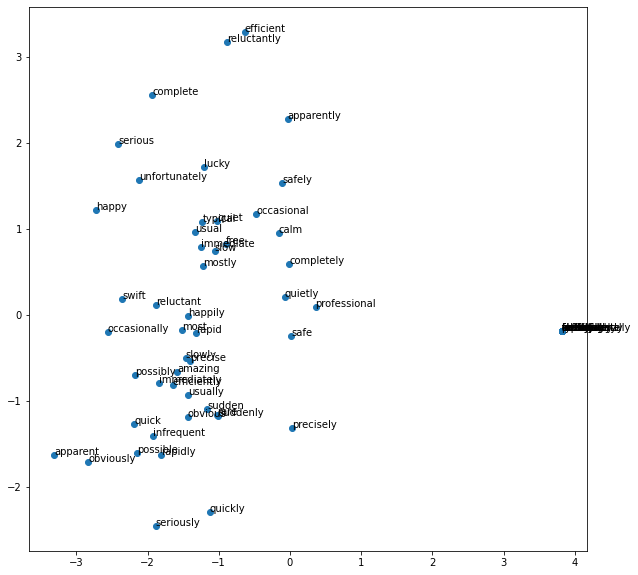

In [87]:
plt.figure(figsize=(10,10))
plt.scatter(x=reduced['X'],y=reduced['Y'])
for idx, value in reduced.iterrows():
    plt.annotate(reduced['word'][idx],value[:-1])

In [103]:
def clean_data(df_col):
    corpus = []
    for item in df_col:
        # item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus